In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block
from bold_dementia.utils.iterables import unique

ATLAS = "schaeffer200"
SOFT = False
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)
labels = tuple(sorted(unique(atlas.macro_labels)))

In [5]:
expname = f"atlas-{ATLAS}_default_ols-cenanom-block"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)

resdf = pd.read_csv(matrices_path / "resdf.csv", index_col=0)
resdf["node_a"] = resdf["edges"].map(lambda edge: edge.split("_")[0])
resdf["node_b"] = resdf["edges"].map(lambda edge: edge.split("_")[1])

mask = np.where(resdf["pvalues_fdr"] < ALPHA, 1, 0) 
resdf["thresholded_beta"] = resdf["beta_AD"] * mask

resdf = resdf.drop("edges", axis=1)

resdf_pv = resdf.pivot(index="node_a" ,columns=["node_b"], values=["beta_AD", "pvalues_raw", "pvalues_fdr", "thresholded_beta"])

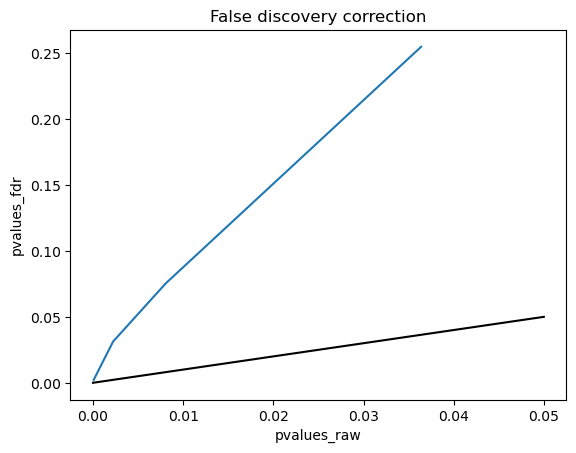

In [6]:
sns.lineplot(resdf[resdf.pvalues_raw < ALPHA], x="pvalues_raw", y="pvalues_fdr")
x = np.linspace(0, ALPHA, 100)
plt.plot(x, x, color="black")
plt.title(f"False discovery correction")
plt.show()

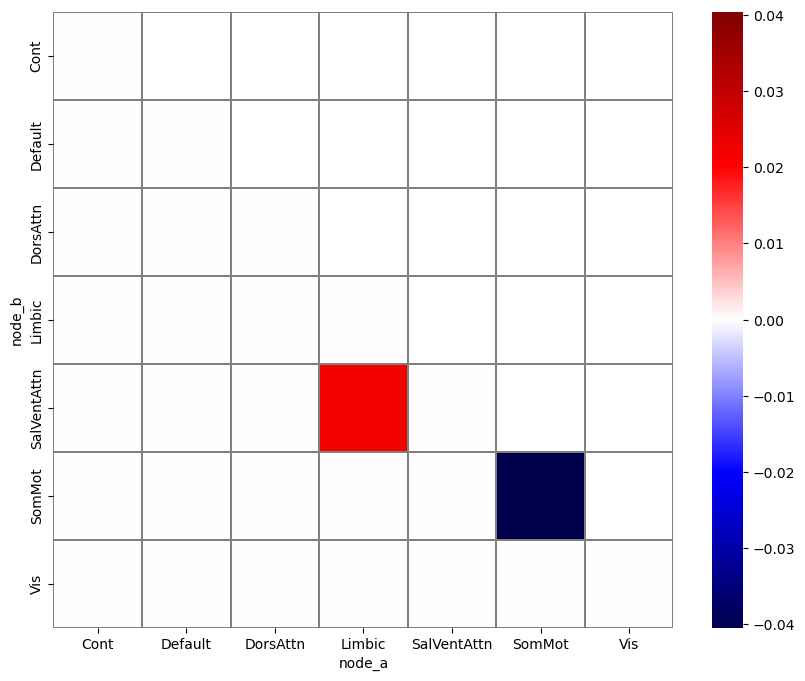

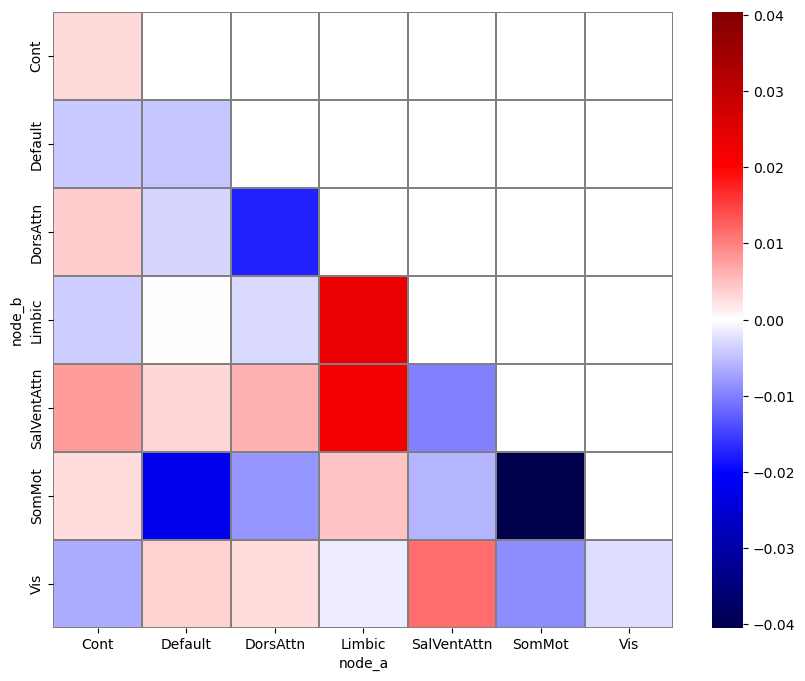

In [7]:
span = max(
    resdf["thresholded_beta"].min().__abs__(),
    resdf["thresholded_beta"].max().__abs__()
)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    resdf_pv.loc[:, "thresholded_beta"].T,
    vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray"
)

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    resdf_pv.loc[:, "beta_AD"].T,
    vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray"
)
plt.show()